In [2]:
!pip install easysnowdata

  Using cached easysnowdata-0.0.11-py2.py3-none-any.whl.metadata (3.1 kB)
  Using cached xee-0.0.19-py3-none-any.whl.metadata (5.7 kB)
  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached py3dep-0.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached earthaccess-0.12.0-py3-none-any.whl.metadata (7.6 kB)
  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached lxml-5.3.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.8 kB)
  Using cached pytkdocs-0.16.2-py3-none-any.whl.metadata (8.8 kB)
  Using cached scikit_image-0.24.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached multimethod-1.12-py3-none-any.whl.metadata (9.6 kB)
  Using cached pqdm-0.2.0-py2.py3-none-any.whl.metadata (3.2 kB)
  Using cached python_cmr-0.13.0-py3-none-any.whl.metadata (10 kB)
  Using cach

In [1]:
%load_ext autoreload
%autoreload 2
import easysnowdata as esd
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import rasterio as rio
import rioxarray
import math, os
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import pandas as pd
import geopandas as gpd
import odc.stac
import xyzservices as xyz
import deep_snow.models
from deep_snow.dataset import norm_dict
from deep_snow.utils import calc_norm, undo_norm, calc_dowy
from tqdm import tqdm
import shutil

/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nc_path = glob("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/jack_subsets/ncs/*")
tif_path = glob("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/jack_subsets/tifs/*")

In [ ]:
ds = xr.open_dataset(tif_path[0])

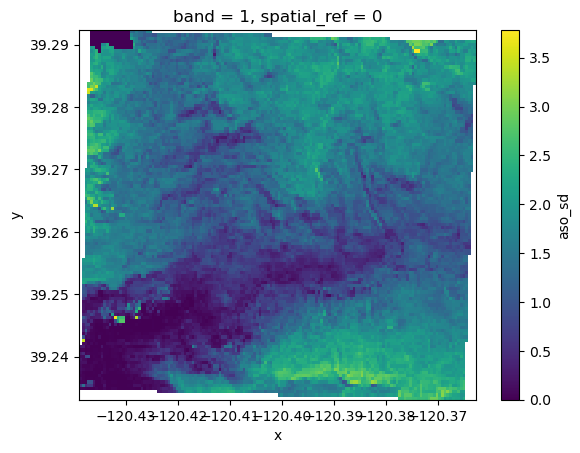

In [4]:
ds['band_data'].plot()

In [5]:
StationCollection = esd.automatic_weather_stations.StationCollection()
all_snotel = StationCollection.all_stations[StationCollection.all_stations.network == 'SNOTEL']

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.


In [6]:
from shapely.geometry import box
raster_bounds = (
    ds.x.min().item(),  # xmin
    ds.y.min().item(),  # ymin
    ds.x.max().item(),  # xmax
    ds.y.max().item()   # ymax
)
raster_polygon = box(*raster_bounds)
raster_gdf = gpd.GeoDataFrame({'geometry': [raster_polygon]}, crs=all_snotel.crs)
points_in_raster = gpd.sjoin(all_snotel, raster_gdf, predicate="intersects")

In [7]:
for f in tqdm(tif_path):
    ds = xr.open_dataset(f)
    raster_bounds = (
    ds.x.min().item(),  # xmin
    ds.y.min().item(),  # ymin
    ds.x.max().item(),  # xmax
    ds.y.max().item()   # ymax
    )
    raster_polygon = box(*raster_bounds)
    raster_gdf = gpd.GeoDataFrame({'geometry': [raster_polygon]}, crs=all_snotel.crs)
    points_in_raster = gpd.sjoin(all_snotel, raster_gdf, predicate="intersects")
    if len(points_in_raster) > 1:
        break
    else:
        continue

  3%|▎         | 92/3540 [00:02<01:47, 32.14it/s]


In [8]:
for i, row in points_in_raster.iterrows():
    break

In [9]:
row.geometry.x, row.geometry.y

(-120.002197265625, 38.69269943237305)

In [10]:
ds.rio.clip(gpd.GeoSeries([row.geometry]))

<xarray.Dataset> Size: 36B
Dimensions:      (band: 1, x: 1, y: 1)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8B -120.0
  * y            (y) float64 8B 38.69
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 4B 2.711

In [124]:
selected_cell = ds.sel(x=x_coord, y=y_coord, method="nearest")

In [158]:
ds.sel(x=x_coord, y=y_coord, method="nearest")['sno_sd'] = 6

In [159]:
ds.where(ds['sno_sd'] == 6, drop=True)

ValueError: zero-size array to reduction operation minimum which has no identity

In [125]:
selected_cell

<xarray.Dataset> Size: 36B
Dimensions:      (band: 1)
Coordinates:
  * band         (band) int64 8B 1
    x            float64 8B -120.0
    y            float64 8B 38.69
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band) float32 4B ...

In [139]:
# Create a 2D array of NaNs with the shape (y, x) that matches the dataset's dimensions
sno_sd_data = np.full((ds['y'].size, ds['x'].size), np.nan)
# Assign the new variable to the dataset with dimensions ('y', 'x')
ds['sno_sd'] = (['y', 'x'], sno_sd_data)

In [148]:
# Direct assignment to the 'sno_sd' variable at the specified coordinates
ds['sno_sd'].loc[dict(x=x_coord, y=y_coord)] = 1

In [151]:
# Apply the condition where 'sno_sd' is 1
result = ds.where(ds['sno_sd'] == 1, drop=True)

In [152]:
result

<xarray.Dataset> Size: 44B
Dimensions:      (band: 1, y: 1, x: 1)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8B -120.0
  * y            (y) float64 8B 38.69
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 4B 2.711
    sno_sd       (y, x) float64 8B 1.0

In [84]:
#all_snotel

In [93]:
from datetime import datetime
f.split('/')[-1].split("_")[4]
datetime.strptime(f.split('/')[-1].split("_")[4], "%Y%m%d").strftime("%Y-%m-%d")

'2023-01-31'

In [94]:
for i in points_in_raster.index.values:
    date = datetime.strptime(f.split('/')[-1].split("_")[4], "%Y%m%d").strftime("%Y-%m-%d")
    StationCollection.get_data(i, variables=['SNWD'], start_date=date, end_date=date)
    break

Dataframe has been added to the Station object. Please use the .data attribute to access.


In [100]:
StationCollection.data.SNWD.values[0]

np.float64(2.667)

In [12]:
from datetime import datetime

In [11]:
nc_path = glob("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/jack_subsets/ncs/*")
tif_path = glob("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/jack_subsets/tifs/*")
StationCollection = esd.automatic_weather_stations.StationCollection()
all_snotel = StationCollection.all_stations[StationCollection.all_stations.network == 'SNOTEL']
for f in tif_path:
    ds = xr.open_dataset(f)
    date = datetime.strptime(f.split('/')[-1].split("_")[4], "%Y%m%d").strftime("%Y-%m-%d") #get the date of the current file
    # create a 128x128 array of NaNs to store snotel sd values
    sno_sd_data = np.full((ds['y'].size, ds['x'].size), np.nan)
    ds['sno_sd'] = (['y', 'x'], sno_sd_data)
    # turn the raster bounds into a geodataframe
    # the workflow is super inefficeint below, but it works for now
    raster_bounds = (
    ds.x.min().item(),
    ds.y.min().item(),
    ds.x.max().item(),
    ds.y.max().item()
    )
    raster_polygon = box(*raster_bounds)
    raster_gdf = gpd.GeoDataFrame({'geometry': [raster_polygon]}, crs=all_snotel.crs)
    points_in_raster = gpd.sjoin(all_snotel, raster_gdf, predicate="intersects")
    if len(points_in_raster) == 0:
        continue
    for i, row in points_in_raster.iterrows():
        StationCollection.get_data(i, variables=['SNWD'], start_date=date, end_date=date)
        snotel_sd = StationCollection.data.SNWD.values[0]

        x,y = row.geometry.x, row.geometry.y

        ds['sno_sd'].loc[dict(x=ds['x'].sel(x=x, method='nearest'), y=ds['y'].sel(y=y, method='nearest'))] = snotel_sd
    break

# it seems like all of the aso_sd values are exactly equal to the snotel_sd values

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.


NameError: name 'datetime' is not defined

In [4]:
from datetime import datetime
from shapely.geometry import box
StationCollection = esd.automatic_weather_stations.StationCollection()
all_snotel = StationCollection.all_stations[StationCollection.all_stations.network == 'SNOTEL']
files = glob("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/subsets_v4/*/*")
s1_variables = [
    "snowon_vv", "snowon_vh", "snowoff_vv", "snowoff_vh"
]
s2_variables = [
    "AOT", "B01", "B02", "B03", "B04", "B05", "B06", "B07",
    "B08", "B09", "B11", "B12", "B8A", "SCL", "WVP", "visual"
]
s1_s2_vars = [s1_variables, s2_variables]
for file in tqdm(files):
    skip_file = False
    ds = xr.open_dataset(file)
    fn = os.path.split(file)[-1]
    source = f"/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/subsets_v4_tif/{file.split("/")[-2]}/{fn.split('.')[0]}.tif"
    tif_ds = xr.open_dataset(source)
    date = datetime.strptime(source.split('/')[-1].split("_")[4], "%Y%m%d").strftime("%Y-%m-%d") #get the date of the current file
    raster_bounds = (
    tif_ds.x.min().item(),
    tif_ds.y.min().item(),
    tif_ds.x.max().item(),
    tif_ds.y.max().item()
    )
    raster_polygon = box(*raster_bounds)
    raster_gdf = gpd.GeoDataFrame({'geometry': [raster_polygon]}, crs=all_snotel.crs)
    points_in_raster = gpd.sjoin(all_snotel, raster_gdf, predicate="intersects")
    if len(points_in_raster) == 0:
        continue
    for i, row in points_in_raster.iterrows():
        StationCollection.get_data(i, variables=['SNWD'], start_date=date, end_date=date)
        snotel_sd = StationCollection.data.SNWD.values[0]

        x,y = row.geometry.x, row.geometry.y

        sno_sd_data = np.full((ds['y'].size, ds['x'].size), np.nan)
        ds['sno_sd'] = (['y', 'x'], sno_sd_data)
        ds['sno_sd'].loc[dict(x=ds['x'].sel(x=x, method='nearest'), y=ds['y'].sel(y=y, method='nearest'))] = snotel_sd

    for i, variables in enumerate(s1_s2_vars):
        data_array = np.stack([ds[var].values for var in variables], axis=-1)
        n_samples = np.prod(data_array.shape[:-1])
        n_features = data_array.shape[-1]
        reshaped_data = data_array.reshape(n_samples, n_features)
        nan_mask = np.isnan(reshaped_data)
        if nan_mask.any():
            column_means = np.nanmean(reshaped_data, axis=0)
            reshaped_data[nan_mask] = np.take(column_means, np.where(nan_mask)[1])
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(reshaped_data)
        pca = PCA(n_components=4)
        pca_result = pca.fit_transform(scaled_data)
        if np.isnan(pca.explained_variance_ratio_).any():
            skip_file = True
            break  # Skip this file
        else:
            if i == 0:
                s1_pc1, s1_pc2 = pca_result[:,0], pca_result[:,1]
            else:
                s2_pc1, s2_pc2, s2_pc3 = pca_result[:,0], pca_result[:,1],  pca_result[:,2]

    if skip_file:
        continue

    dowy_1d = calc_dowy(pd.to_datetime(fn.split('_')[4]).dayofyear)
    dowy_array = np.full((128, 128), dowy_1d)

    new_ds = xr.Dataset({
        "aso_sd": (["x", "y"], ds['aso_sd'].values),
        "fcf": (["x", "y"], ds["fcf"].values),
        "elevation": (["x", "y"], ds["elevation"].values),
        "slope": (["x", "y"], ds["slope"].values),
        "tri": (["x", "y"], ds["tri"].values),
        "tpi": (["x", "y"], ds["tpi"].values),
        "latitude": (["x", "y"], ds["latitude"].values),
        "longitude": (["x", "y"], ds["longitude"].values),
        "s1_pc1": (["x", "y"], s1_pc1.reshape(128, 128)),
        "s1_pc2": (["x", "y"], s1_pc2.reshape(128, 128)),
        "s2_pc1": (["x", "y"], s2_pc1.reshape(128, 128)),
        "s2_pc2": (["x", "y"], s2_pc2.reshape(128, 128)),
        "s2_pc3": (["x", "y"], s2_pc3.reshape(128, 128)),
        "dowy": (["x", "y"], dowy_array,),
        "sno_sd": (["x", "y"], ds["sno_sd"].values)
    })

    
    destination = f"/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/jack_subsets_snotel/tifs/{fn.split('.')[0]}.tif"

    new_ds.to_netcdf(f"/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/jack_subsets_snotel/ncs/{fn}")
    shutil.copy(source, destination)

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.


  0%|          | 6/4406 [00:00<06:55, 10.58it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


  0%|          | 15/4406 [00:03<14:09,  5.17it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


  5%|▍         | 210/4406 [00:25<06:57, 10.05it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


  5%|▍         | 220/4406 [00:27<08:42,  8.01it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


  5%|▌         | 221/4406 [00:27<15:31,  4.49it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


  5%|▌         | 223/4406 [00:28<18:42,  3.73it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


  9%|▊         | 385/4406 [00:45<07:30,  8.92it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


  9%|▉         | 390/4406 [00:46<09:40,  6.92it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


  9%|▉         | 394/4406 [00:47<10:47,  6.19it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


  9%|▉         | 400/4406 [00:48<08:55,  7.48it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 10%|▉         | 426/4406 [00:51<05:48, 11.43it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 10%|▉         | 430/4406 [00:52<11:17,  5.86it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 10%|▉         | 436/4406 [00:53<10:33,  6.26it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 12%|█▏        | 517/4406 [01:00<04:55, 13.17it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 12%|█▏        | 533/4406 [01:02<05:48, 11.10it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 12%|█▏        | 549/4406 [01:05<06:36,  9.72it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


 13%|█▎        | 553/4406 [01:06<12:07,  5.30it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 13%|█▎        | 555/4406 [01:07<16:31,  3.88it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 13%|█▎        | 558/4406 [01:08<15:54,  4.03it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 13%|█▎        | 564/4406 [01:09<12:02,  5.32it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


 13%|█▎        | 583/4406 [01:12<04:56, 12.89it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 14%|█▎        | 597/4406 [01:13<05:51, 10.82it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 14%|█▍        | 623/4406 [01:17<05:10, 12.19it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 14%|█▍        | 629/4406 [01:18<08:16,  7.60it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


 14%|█▍        | 631/4406 [01:19<19:13,  3.27it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 15%|█▍        | 655/4406 [01:22<06:12, 10.08it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 15%|█▍        | 659/4406 [01:23<09:47,  6.37it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


 15%|█▌        | 664/4406 [01:25<13:10,  4.74it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 15%|█▌        | 667/4406 [01:26<13:40,  4.56it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 15%|█▌        | 673/4406 [01:26<09:34,  6.50it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 15%|█▌        | 680/4406 [01:28<08:52,  6.99it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 15%|█▌        | 682/4406 [01:29<14:31,  4.27it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▌        | 691/4406 [01:30<07:43,  8.01it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▌        | 693/4406 [01:31<13:25,  4.61it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▌        | 695/4406 [01:31<16:25,  3.76it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▌        | 697/4406 [01:32<18:15,  3.39it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▌        | 698/4406 [01:33<19:45,  3.13it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▌        | 702/4406 [01:34<15:41,  3.94it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▌        | 707/4406 [01:35<11:38,  5.30it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▌        | 712/4406 [01:36<12:05,  5.09it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▋        | 720/4406 [01:37<07:59,  7.69it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 16%|█▋        | 726/4406 [01:38<10:05,  6.08it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 17%|█▋        | 748/4406 [01:41<04:51, 12.56it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 17%|█▋        | 766/4406 [01:43<04:56, 12.29it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 774/4406 [01:44<07:41,  7.87it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 776/4406 [01:45<10:07,  5.97it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 777/4406 [01:45<13:46,  4.39it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 18%|█▊        | 785/4406 [01:46<07:08,  8.46it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 787/4406 [01:46<10:15,  5.88it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 788/4406 [01:47<14:50,  4.06it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 18%|█▊        | 791/4406 [01:47<09:54,  6.08it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 792/4406 [01:48<16:39,  3.62it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 18%|█▊        | 805/4406 [01:49<05:11, 11.55it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 813/4406 [01:50<06:37,  9.04it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 815/4406 [01:50<09:20,  6.40it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 19%|█▊        | 816/4406 [01:51<11:40,  5.12it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 19%|█▊        | 825/4406 [01:52<07:05,  8.41it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 19%|█▊        | 826/4406 [01:52<10:24,  5.73it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 19%|█▉        | 827/4406 [01:52<13:10,  4.53it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 19%|█▉        | 829/4406 [01:53<10:08,  5.88it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 19%|█▉        | 831/4406 [01:53<12:24,  4.80it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 19%|█▉        | 840/4406 [01:54<06:39,  8.93it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 19%|█▉        | 846/4406 [01:55<08:31,  6.96it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 24%|██▎       | 1044/4406 [02:14<04:32, 12.34it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 28%|██▊       | 1228/4406 [02:31<06:01,  8.78it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 32%|███▏      | 1413/4406 [02:51<05:21,  9.30it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 36%|███▋      | 1602/4406 [03:13<05:31,  8.46it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 37%|███▋      | 1619/4406 [03:16<04:39,  9.96it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 37%|███▋      | 1622/4406 [03:16<07:59,  5.81it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 37%|███▋      | 1641/4406 [03:19<06:41,  6.89it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 37%|███▋      | 1650/4406 [03:21<05:52,  7.82it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 38%|███▊      | 1656/4406 [03:22<07:26,  6.16it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 38%|███▊      | 1667/4406 [03:24<06:38,  6.88it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 38%|███▊      | 1675/4406 [03:26<05:36,  8.10it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 38%|███▊      | 1681/4406 [03:27<08:46,  5.18it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 38%|███▊      | 1693/4406 [03:29<05:32,  8.16it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 49%|████▊     | 2146/4406 [04:18<03:57,  9.50it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 50%|████▉     | 2186/4406 [04:24<04:04,  9.09it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 50%|████▉     | 2199/4406 [04:25<04:29,  8.20it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


 50%|████▉     | 2200/4406 [04:27<16:26,  2.24it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 50%|█████     | 2204/4406 [04:28<09:27,  3.88it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 50%|█████     | 2207/4406 [04:28<08:52,  4.13it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 50%|█████     | 2208/4406 [04:29<11:15,  3.26it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 55%|█████▌    | 2437/4406 [04:57<02:52, 11.39it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 55%|█████▌    | 2439/4406 [04:57<06:17,  5.21it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 56%|█████▌    | 2477/4406 [05:02<05:36,  5.74it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 57%|█████▋    | 2491/4406 [05:05<03:55,  8.13it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 57%|█████▋    | 2493/4406 [05:06<09:12,  3.46it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 57%|█████▋    | 2515/4406 [05:09<02:43, 11.54it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 57%|█████▋    | 2521/4406 [05:10<03:47,  8.28it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 57%|█████▋    | 2533/4406 [05:12<03:44,  8.35it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 58%|█████▊    | 2545/4406 [05:13<03:08,  9.89it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 58%|█████▊    | 2549/4406 [05:14<03:56,  7.85it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 58%|█████▊    | 2551/4406 [05:15<06:06,  5.06it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 58%|█████▊    | 2555/4406 [05:15<04:12,  7.33it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 58%|█████▊    | 2557/4406 [05:16<08:33,  3.60it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 58%|█████▊    | 2570/4406 [05:18<03:50,  7.96it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 58%|█████▊    | 2573/4406 [05:18<05:06,  5.99it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 58%|█████▊    | 2574/4406 [05:19<10:03,  3.04it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 59%|█████▊    | 2579/4406 [05:20<04:21,  6.99it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 59%|█████▊    | 2588/4406 [05:22<04:40,  6.48it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 59%|█████▉    | 2590/4406 [05:23<08:50,  3.42it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 59%|█████▉    | 2595/4406 [05:23<04:34,  6.59it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 59%|█████▉    | 2597/4406 [05:24<06:30,  4.63it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 59%|█████▉    | 2598/4406 [05:25<08:42,  3.46it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 59%|█████▉    | 2608/4406 [05:25<03:13,  9.29it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 59%|█████▉    | 2610/4406 [05:26<05:42,  5.24it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 59%|█████▉    | 2617/4406 [05:27<03:32,  8.41it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 59%|█████▉    | 2621/4406 [05:28<04:28,  6.64it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|█████▉    | 2623/4406 [05:28<05:02,  5.89it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 60%|█████▉    | 2624/4406 [05:28<04:41,  6.34it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|█████▉    | 2626/4406 [05:29<06:06,  4.85it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|█████▉    | 2627/4406 [05:29<06:43,  4.41it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|█████▉    | 2634/4406 [05:30<04:00,  7.37it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|█████▉    | 2636/4406 [05:31<05:08,  5.74it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 60%|█████▉    | 2640/4406 [05:31<03:34,  8.23it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|██████    | 2646/4406 [05:32<03:39,  8.00it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|██████    | 2660/4406 [05:34<03:21,  8.65it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|██████    | 2661/4406 [05:34<04:47,  6.08it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 60%|██████    | 2663/4406 [05:34<03:59,  7.28it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|██████    | 2664/4406 [05:35<05:41,  5.11it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 61%|██████    | 2668/4406 [05:35<04:03,  7.14it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 61%|██████    | 2670/4406 [05:35<05:07,  5.65it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 61%|██████    | 2678/4406 [05:37<03:41,  7.79it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 61%|██████    | 2679/4406 [05:37<05:57,  4.83it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 61%|██████    | 2680/4406 [05:38<07:01,  4.10it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 61%|██████    | 2686/4406 [05:38<03:05,  9.29it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 61%|██████    | 2690/4406 [05:39<04:08,  6.91it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 61%|██████▏   | 2699/4406 [05:40<03:54,  7.28it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 61%|██████▏   | 2700/4406 [05:40<06:23,  4.45it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 61%|██████▏   | 2707/4406 [05:41<04:12,  6.72it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 61%|██████▏   | 2708/4406 [05:42<06:41,  4.23it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 61%|██████▏   | 2709/4406 [05:42<07:56,  3.56it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 62%|██████▏   | 2712/4406 [05:42<04:28,  6.32it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 62%|██████▏   | 2713/4406 [05:43<06:15,  4.50it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 62%|██████▏   | 2714/4406 [05:43<05:22,  5.25it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 62%|██████▏   | 2716/4406 [05:44<06:38,  4.24it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 62%|██████▏   | 2717/4406 [05:44<08:10,  3.44it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 62%|██████▏   | 2724/4406 [05:45<04:16,  6.55it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 62%|██████▏   | 2726/4406 [05:46<05:02,  5.55it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 62%|██████▏   | 2730/4406 [05:46<03:40,  7.62it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 62%|██████▏   | 2731/4406 [05:46<05:16,  5.29it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 62%|██████▏   | 2735/4406 [05:47<03:27,  8.05it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 62%|██████▏   | 2749/4406 [05:49<03:15,  8.47it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 62%|██████▏   | 2751/4406 [05:49<04:18,  6.40it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 62%|██████▏   | 2753/4406 [05:49<03:40,  7.50it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 63%|██████▎   | 2754/4406 [05:50<04:54,  5.61it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 63%|██████▎   | 2759/4406 [05:50<03:39,  7.51it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 63%|██████▎   | 2760/4406 [05:52<10:48,  2.54it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 63%|██████▎   | 2767/4406 [05:53<04:38,  5.88it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 63%|██████▎   | 2769/4406 [05:53<06:05,  4.48it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 63%|██████▎   | 2770/4406 [05:54<06:57,  3.92it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 63%|██████▎   | 2776/4406 [05:54<03:33,  7.64it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 63%|██████▎   | 2780/4406 [05:55<04:17,  6.31it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 63%|██████▎   | 2790/4406 [05:56<03:00,  8.94it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 64%|██████▎   | 2798/4406 [05:57<04:20,  6.18it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 64%|██████▎   | 2799/4406 [05:58<06:48,  3.93it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 64%|██████▎   | 2800/4406 [05:58<08:00,  3.34it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 64%|██████▎   | 2803/4406 [05:59<04:37,  5.77it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 64%|██████▎   | 2804/4406 [05:59<06:22,  4.19it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 64%|██████▎   | 2805/4406 [05:59<05:33,  4.80it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 64%|██████▎   | 2807/4406 [06:00<07:04,  3.77it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 64%|██████▎   | 2808/4406 [06:00<08:15,  3.23it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 81%|████████  | 3552/4406 [07:22<01:31,  9.34it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 81%|████████▏ | 3580/4406 [07:25<01:15, 10.89it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 81%|████████▏ | 3582/4406 [07:25<02:18,  5.95it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 82%|████████▏ | 3603/4406 [07:28<01:06, 12.15it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 82%|████████▏ | 3609/4406 [07:28<01:28,  9.02it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 83%|████████▎ | 3645/4406 [07:34<02:01,  6.26it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 83%|████████▎ | 3652/4406 [07:35<01:40,  7.47it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 83%|████████▎ | 3667/4406 [07:37<01:49,  6.74it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 83%|████████▎ | 3674/4406 [07:39<01:36,  7.55it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 83%|████████▎ | 3676/4406 [07:39<02:34,  4.73it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 84%|████████▍ | 3693/4406 [07:41<01:08, 10.42it/s]/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 84%|████████▍ | 3695/4406 [07:42<01:53,  6.25it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 85%|████████▌ | 3765/4406 [07:48<01:26,  7.44it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 86%|████████▌ | 3770/4406 [07:49<01:48,  5.88it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 86%|████████▌ | 3788/4406 [07:52<01:16,  8.10it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 86%|████████▌ | 3793/4406 [07:53<01:37,  6.30it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 86%|████████▋ | 3801/4406 [07:55<01:38,  6.16it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.
Dataframe has been added to the Station object. Please use the .data attribute to access.


 86%|████████▋ | 3808/4406 [07:57<01:36,  6.17it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 86%|████████▋ | 3810/4406 [07:57<02:01,  4.90it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 87%|████████▋ | 3814/4406 [07:58<01:55,  5.11it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 87%|████████▋ | 3826/4406 [08:00<01:11,  8.11it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 87%|████████▋ | 3827/4406 [08:01<03:02,  3.17it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 87%|████████▋ | 3832/4406 [08:02<01:56,  4.93it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 87%|████████▋ | 3835/4406 [08:03<02:14,  4.24it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 87%|████████▋ | 3842/4406 [08:04<01:33,  6.06it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 87%|████████▋ | 3843/4406 [08:05<02:56,  3.19it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 91%|█████████▏| 4029/4406 [08:28<00:44,  8.53it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 92%|█████████▏| 4032/4406 [08:29<01:28,  4.24it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 95%|█████████▌| 4200/4406 [08:46<00:22,  9.19it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 96%|█████████▌| 4208/4406 [08:48<00:23,  8.37it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 96%|█████████▌| 4214/4406 [08:49<00:25,  7.64it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 96%|█████████▌| 4224/4406 [08:50<00:25,  7.07it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


 96%|█████████▌| 4231/4406 [08:52<00:23,  7.33it/s]

Dataframe has been added to the Station object. Please use the .data attribute to access.


100%|██████████| 4406/4406 [09:10<00:00,  8.01it/s]
